In [1]:
import numpy as np
from fractions import Fraction
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

How many attributes do you have? 3
Enter the name of attribute 1: s
Enter the file path for Images 1: D:\GIS Data\Rs Paper\Drainage_density_1000.tif
Enter the name of attribute 2: w
Enter the file path for Images 2: D:\GIS Data\Rs Paper\Data\Rc_swabi_lineament_den.tif
Enter the name of attribute 3: g
Enter the file path for Images 3: D:\GIS Data\Rs Paper\Data\swabi_geology.tif

Enter your judgments as fractions or decimals (e.g.1 to 9 or 1/9.):

How much more important is s than w?
s vs w: 1/6
How much more important is s than g?
s vs g: 7
How much more important is w than g?
w vs g: 3


 SUMMARY

Pairwise Comparison Matrix:
[[1.         0.16666667 7.        ]
 [6.         1.         3.        ]
 [0.14285714 0.33333333 1.        ]]

Weights of Attributes:
s: 0.2608
w: 0.6494
g: 0.0898

Lambda Max: 3.8250555308583545
Consistency Index (CI): 0.41252776542917724
Consistency Ratio (CR): 0.7112547679813401
Matrix is not consistent.


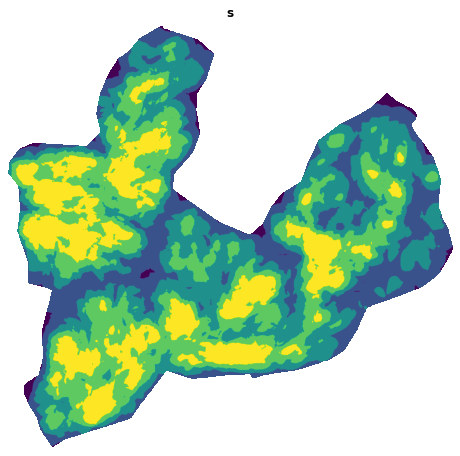

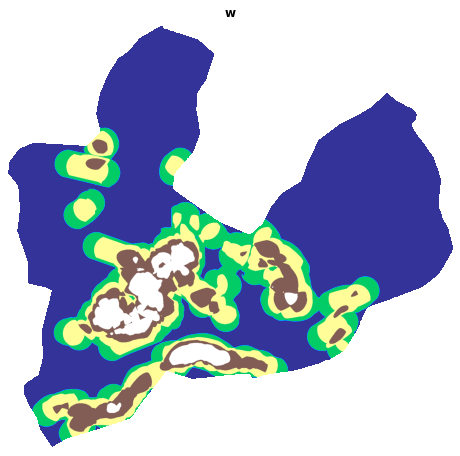

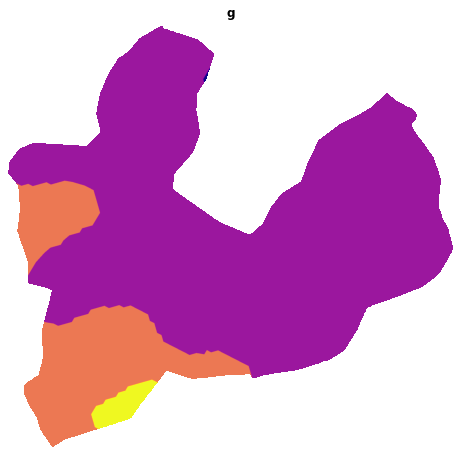

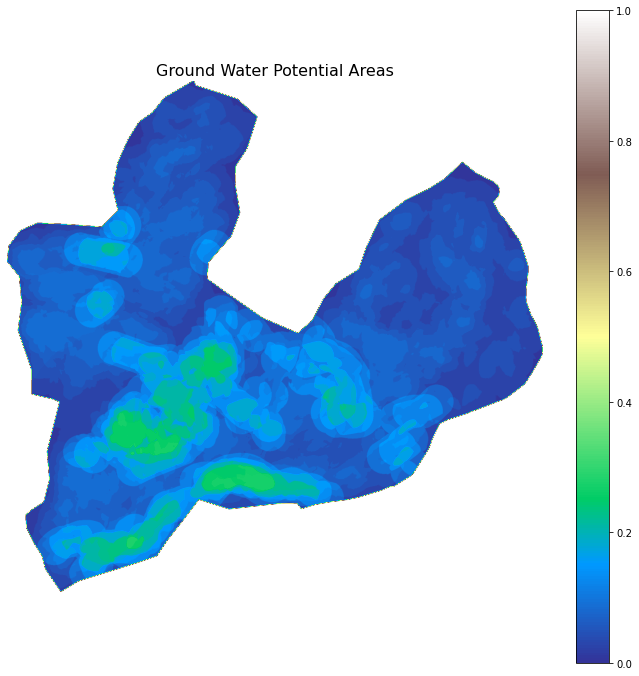

In [22]:
title=[]
def pairwise_comparison_matrix(attributes):
    n = len(attributes)
    comparison_matrix = np.zeros((n, n))
    
    print("\nEnter your judgments as fractions or decimals (e.g.1 to 9 or 1/9.):\n")
    
    for i in range(n):
        for j in range(i + 1, n):
            print(f"How much more important is {attributes[i]} than {attributes[j]}?")
            comparison = input(f"{attributes[i]} vs {attributes[j]}: ")
            
            try:
                comparison_value = float(comparison)
                comparison_matrix[i][j] = comparison_value
                comparison_matrix[j][i] = 1 / comparison_value
            except ValueError:
                fraction_value = Fraction(comparison)
                comparison_matrix[i][j] = fraction_value
                comparison_matrix[j][i] = 1 / fraction_value
    
    for i in range(n):
        comparison_matrix[i][i] = 1  # Set diagonal elements to 1
    
    return comparison_matrix

def calculate_weights(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_eigenvalue_index = np.argmax(eigenvalues)
    principal_eigenvector = np.real(eigenvectors[:, max_eigenvalue_index])
    weights = principal_eigenvector / np.sum(principal_eigenvector)
    return weights

def check_consistency(matrix, weights):
    lambda_max = np.max(np.dot(matrix, weights) / weights)
    consistency_index = (lambda_max - len(matrix)) / (len(matrix) - 1)
    random_index = {2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45}
    consistency_ratio = consistency_index / random_index[len(matrix)]
    return lambda_max, consistency_index, consistency_ratio


num_attributes = int(input("How many attributes do you have? "))

attributes = []
file_paths = []
for i in range(num_attributes):
    attribute = input(f"Enter the name of attribute {i + 1}: ")
    path = input(f"Enter the file path for Images {i + 1}: ")
    file_paths.append(path)
    attributes.append(attribute)

title=attributes
comparison_matrix = pairwise_comparison_matrix(attributes)
print("\n\n SUMMARY")
print("\nPairwise Comparison Matrix:")
print(comparison_matrix)

weights = calculate_weights(comparison_matrix)

print("\nWeights of Attributes:")
for i, weight in enumerate(weights):
    print(f"{attributes[i]}: {weight:.4f}")

lambda_max, consistency_index, consistency_ratio = check_consistency(comparison_matrix, weights)

print("\nLambda Max:", lambda_max)
print("Consistency Index (CI):", consistency_index)
print("Consistency Ratio (CR):", consistency_ratio)

if consistency_ratio < 0.1:
    print("Matrix is consistent.")
else:
    print("Matrix is not consistent.")

#showing Raster Files

titles = attributes

# Loop through file paths and display TIFF images with customizations
for idx, file_path in enumerate(file_paths):
    try:
        # Open the TIFF file
        raster = rasterio.open(file_path)

        # Create a Matplotlib figure and axis
        fig, ax = plt.subplots(figsize=(8, 8))  # Double the size of the figure

        # Show the raster image with customized options
        if idx == 1:  # Customizing LULC image
            cmap = 'terrain'  # Using qualitative colormap for different classes
        elif idx == 2:  # Customizing rainfall image
            cmap = 'plasma'  # Using blue colormap for rainfall
        else:
            cmap = 'viridis'  # Default colormap for other images

        show(raster, ax=ax, cmap=cmap, title=titles[idx])  # Display the raster image

        # Customize axis labels and ticks
        ax.set_axis_off()  # Turn off axis labels and ticks

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

       
    
#displayin overlay Map
def weighted_overlay(raster_paths, weights):
    output_raster = None

    for i, raster_path in enumerate(raster_paths):
        with rasterio.open(raster_path) as src:
            raster = src.read(1)

            if raster is None:
                print(f"Error: Unable to read raster data from {raster_path}")
                continue

            # Normalize raster values
            min_val = raster.min()
            max_val = raster.max()

            if min_val == max_val:
                print(f"Error: Raster values in {raster_path} are constant. Unable to normalize.")
                continue

            normalized_raster = (raster - min_val) / (max_val - min_val)

            if normalized_raster is None:
                print(f"Error: Normalized raster is None for {raster_path}")
                continue

            # Check for shape consistency
            if output_raster is not None and output_raster.shape != normalized_raster.shape:
                print(f"Error: Inconsistent shapes between rasters. Skipping {raster_path}")
                continue

            # Weighted overlay
            if output_raster is None:
                output_raster = weights[i] * normalized_raster
            else:
                output_raster += weights[i] * normalized_raster

    return output_raster



result = weighted_overlay(file_paths, weights)

# Visualize the resulting array as an image with larger size and no axis
plt.figure(figsize=(12, 12))  # Set the figure size (width, height)
plt.imshow(result, cmap='terrain')  # Assuming grayscale colormap
plt.colorbar()
plt.axis('off')  # Turn off axis
plt.title('Ground Water Potential Areas', fontsize=16)  # Add a title
plt.show()


In [20]:
# file_paths = [
#     'D:\GIS Data\Rs Paper\Drainage_density_1000.tif',
#     "D:\GIS Data\Rs Paper\Data\Rc_swabi_lineament_den.tif",
#     'D:\GIS Data\Rs Paper\Data\swabi_geology.tif'
# ]